# 10. Pruning, Distillation, and Speculative Decoding

> ⚡Compute Note: I recommend running this notebook on a node with 1x H200 GPU. 

In this tutorial we explore three widely-used techniques for compressing and accelerating neural networks:

1. **Magnitude pruning**, which removes the parameters that contribute the least to a model's predictions.
2. **Knowledge distillation**, which transfers knowledge from a larger teacher network into a smaller student.
3. **Speculative decoding**, which speeds up auto-regressive text generation by combining a lightweight draft model with a larger target model.

We start with a toy classification problem so that we can reason about the effects of pruning and distillation visually. We then move to a causal language modeling setup inspired by the `Qwen3` family of models where we leverage Hugging Face's `Trainer` API with `LoRA` and finish with speculative decoding.


## 1. Setup

We rely on PyTorch for modeling, `matplotlib` for visualization, and a few helper utilities for tracking progress. The code below also defines helper functions for reproducibility and device management.

In [ ]:
import math
import random
import time
from dataclasses import dataclass
from typing import Callable, Dict, Iterable, List, Optional, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

Using device: cuda


## 2. A Toy Classification Task

To make the ideas concrete we create a two-dimensional synthetic dataset with two classes that *are* linearly separable. That allows us to train a single-layer linear classifier and visualize both the data and the resulting decision boundary easily.

We draw points from two Gaussians and assign labels $y \in \{0, 1\}$. The model learns a simple linear decision boundary $f(\mathbf{x}) = \mathbf{w}^	op \mathbf{x} + b$. The logits are converted into probabilities via the sigmoid function and we optimize the binary cross-entropy loss:

$$
\ell(\mathbf{w}, b) = - \frac{1}{N} \sum_{i=1}^N \Big[y_i \log \sigma(f(\mathbf{x}_i)) + (1 - y_i) \log (1 - \sigma(f(\mathbf{x}_i)))\Big].
$$

In [2]:
def make_linear_dataset(n_per_class: int = 200, spread: float = 0.6):
    mean_pos = torch.tensor([1.5, 1.5])
    mean_neg = torch.tensor([-1.5, -1.5])
    cov = torch.eye(2) * spread
    pos = torch.distributions.MultivariateNormal(mean_pos, cov).sample((n_per_class,))
    neg = torch.distributions.MultivariateNormal(mean_neg, cov).sample((n_per_class,))
    X = torch.cat([pos, neg], dim=0)
    y = torch.cat([torch.ones(n_per_class), torch.zeros(n_per_class)], dim=0)
    perm = torch.randperm(len(X))
    return X[perm], y.long()[perm]

X, y = make_linear_dataset()
print(X.shape, y.shape)

torch.Size([400, 2]) torch.Size([400])


Let's visualize the data. 

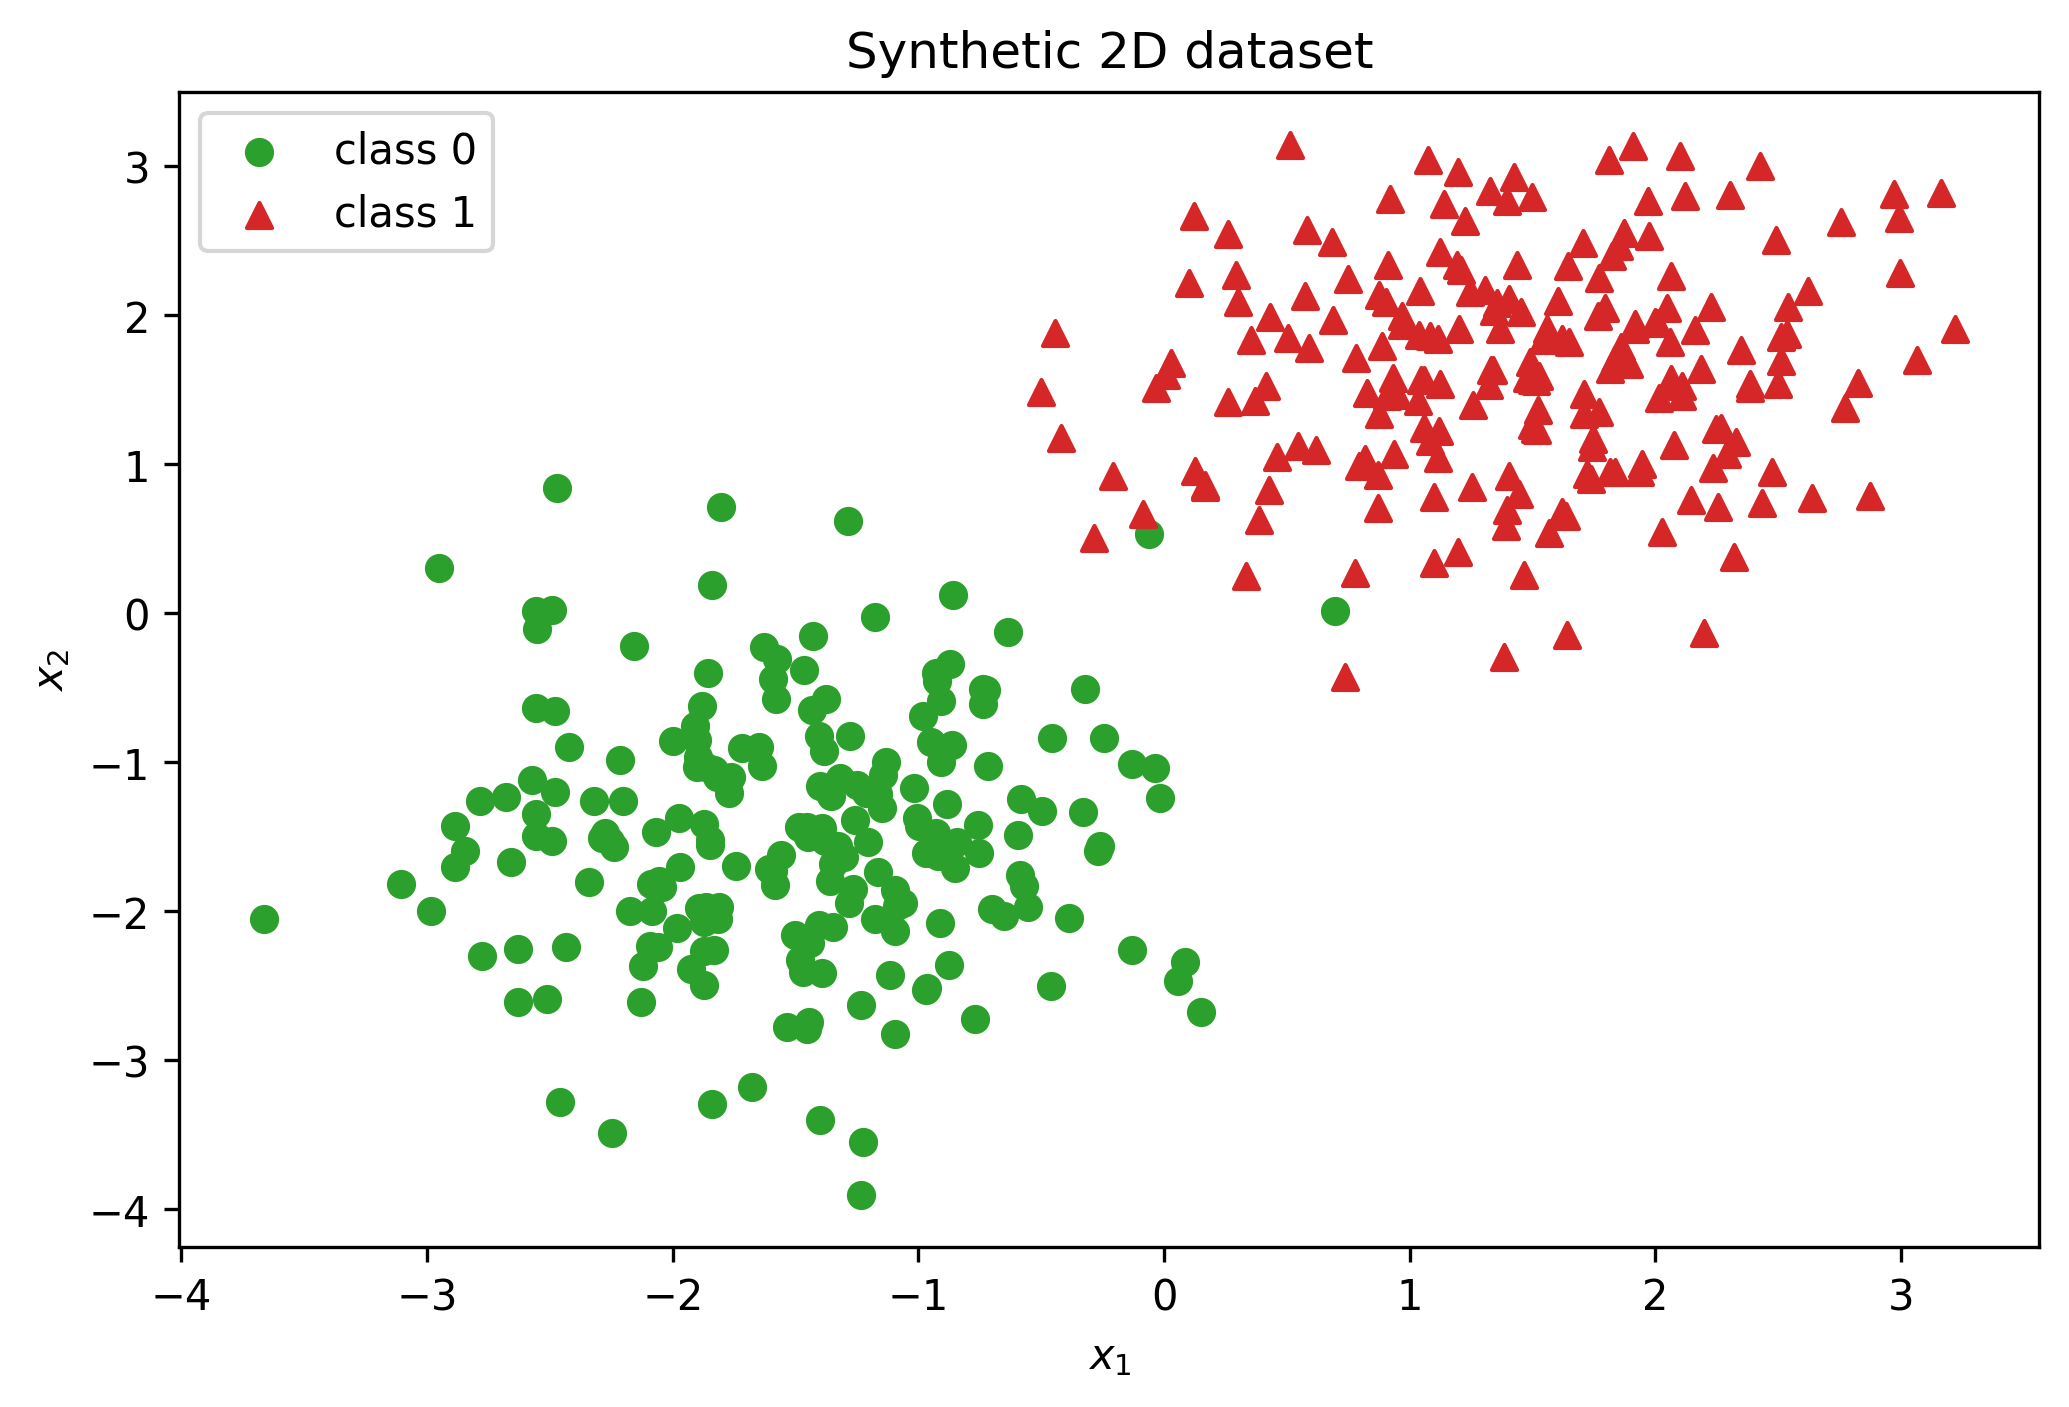

In [13]:
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
    mask = y == label
    ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, label=f'class {label}')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Synthetic 2D dataset')
ax.legend()
plt.show()

### 2.1 Training a Single-Layer Classifier

Our model is a single dense layer followed by a sigmoid. For convenience we package training and evaluation loops that report the loss and accuracy on train/test splits.

In [21]:
class LinearClassifier(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.linear = nn.Linear(in_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x).squeeze(-1)


def train_classifier(model: nn.Module, data: Tuple[torch.Tensor, torch.Tensor], epochs: int = 200, lr: float = 0.1):
    X, y = data
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        model.train()
        logits = model(X)
        loss = F.binary_cross_entropy_with_logits(logits, y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            preds = (logits.sigmoid() > 0.5).long()
            acc = (preds == y).float().mean().item()
        history.append((loss.item(), acc))
    return history


def plot_history(history, title: str):
    losses, accs = zip(*history)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=300)
    ax[0].plot(losses)
    ax[0].set_title(f'{title} loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('loss')
    ax[1].plot(accs)
    ax[1].set_title(f'{title} accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    plt.show()

Let's see the training curves.

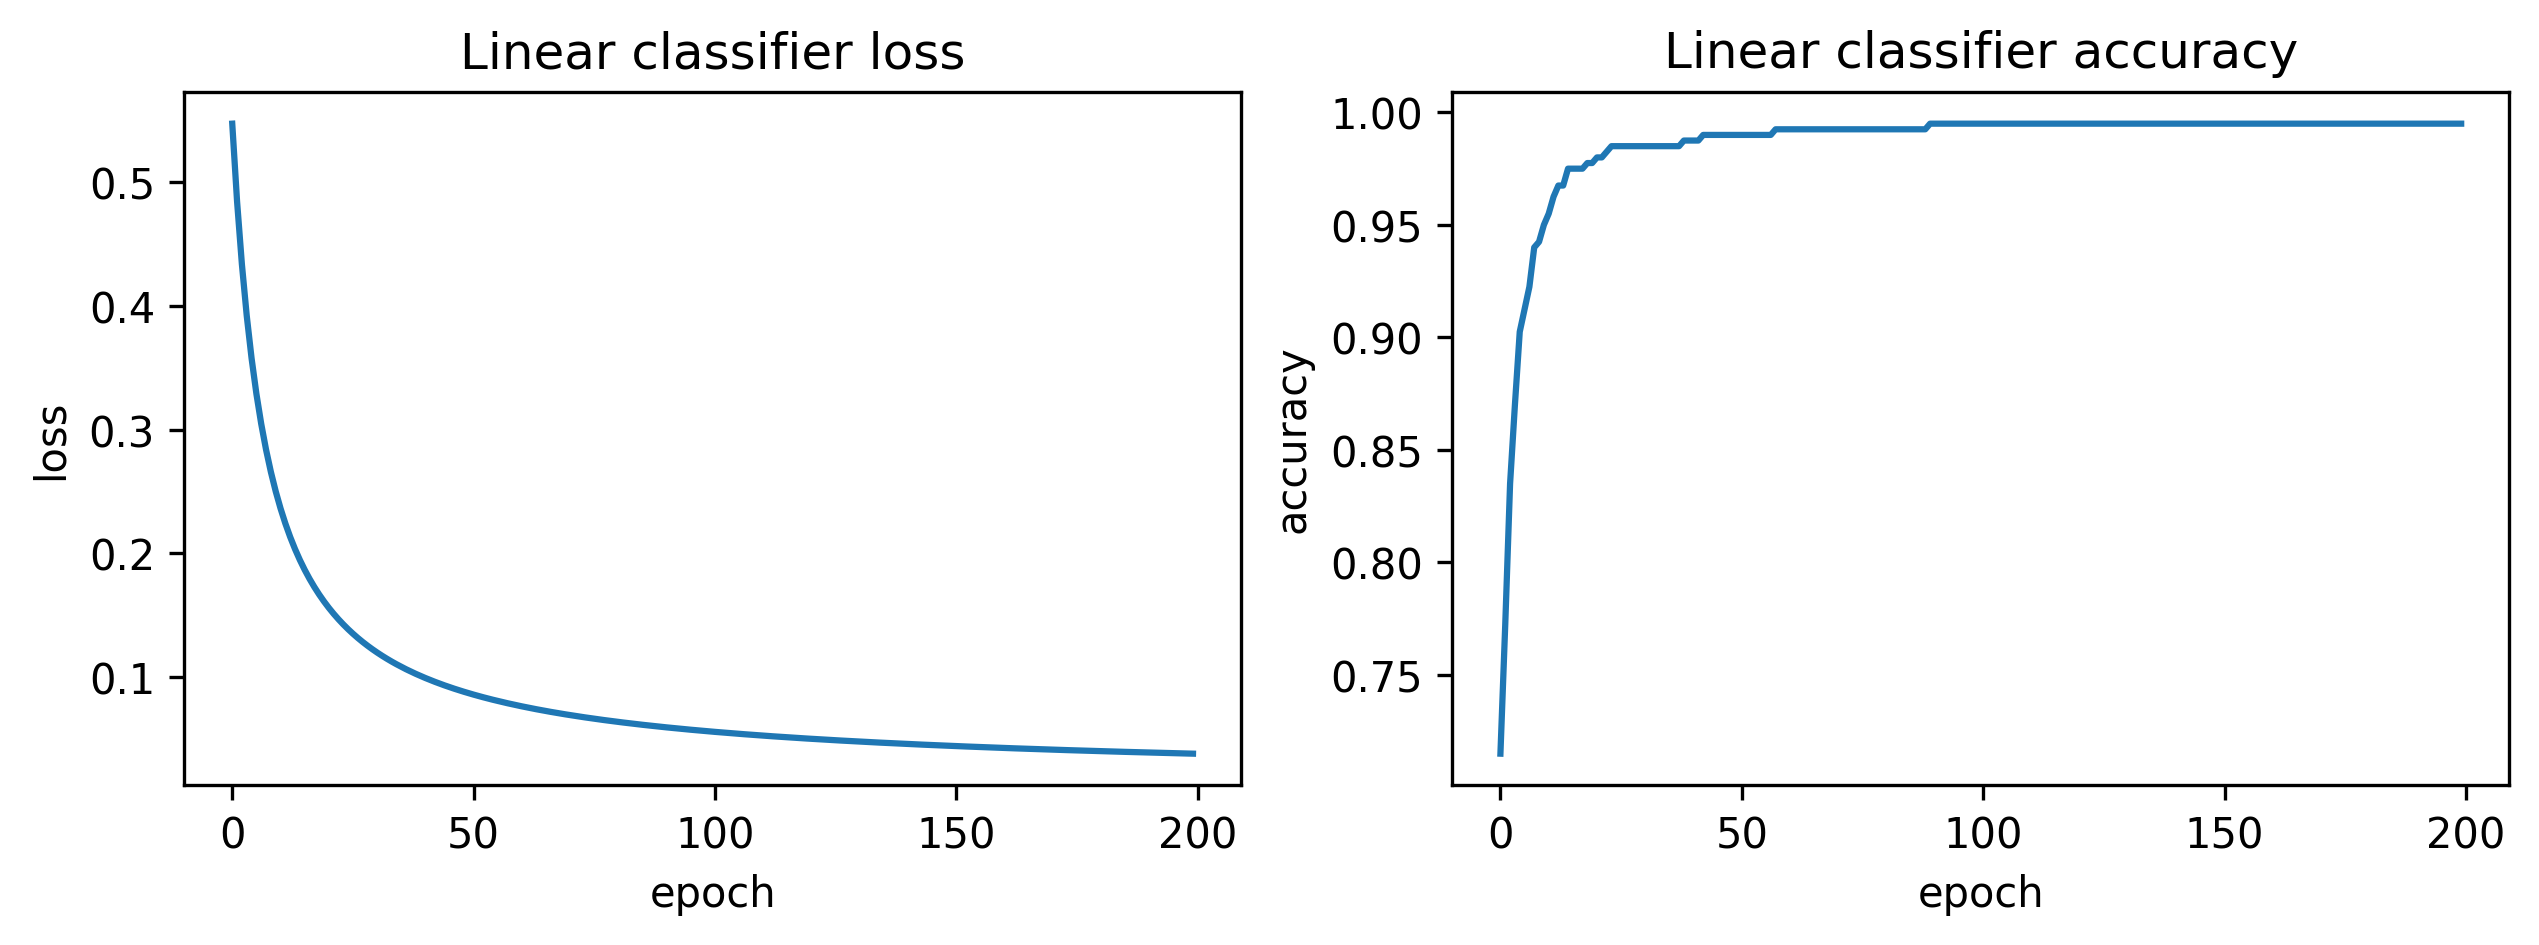

In [30]:
model = LinearClassifier(in_dim=2)
history = train_classifier(model, (X, y))
plot_history(history, 'Linear classifier')

### 2.2 Visualizing the Decision Boundary

The decision boundary is the set of points where the predicted probability equals 0.5, i.e. $f(\mathbf{x}) = 0$. We evaluate the model on a dense grid and color the prediction regions to see how the linear separator aligns with the data.

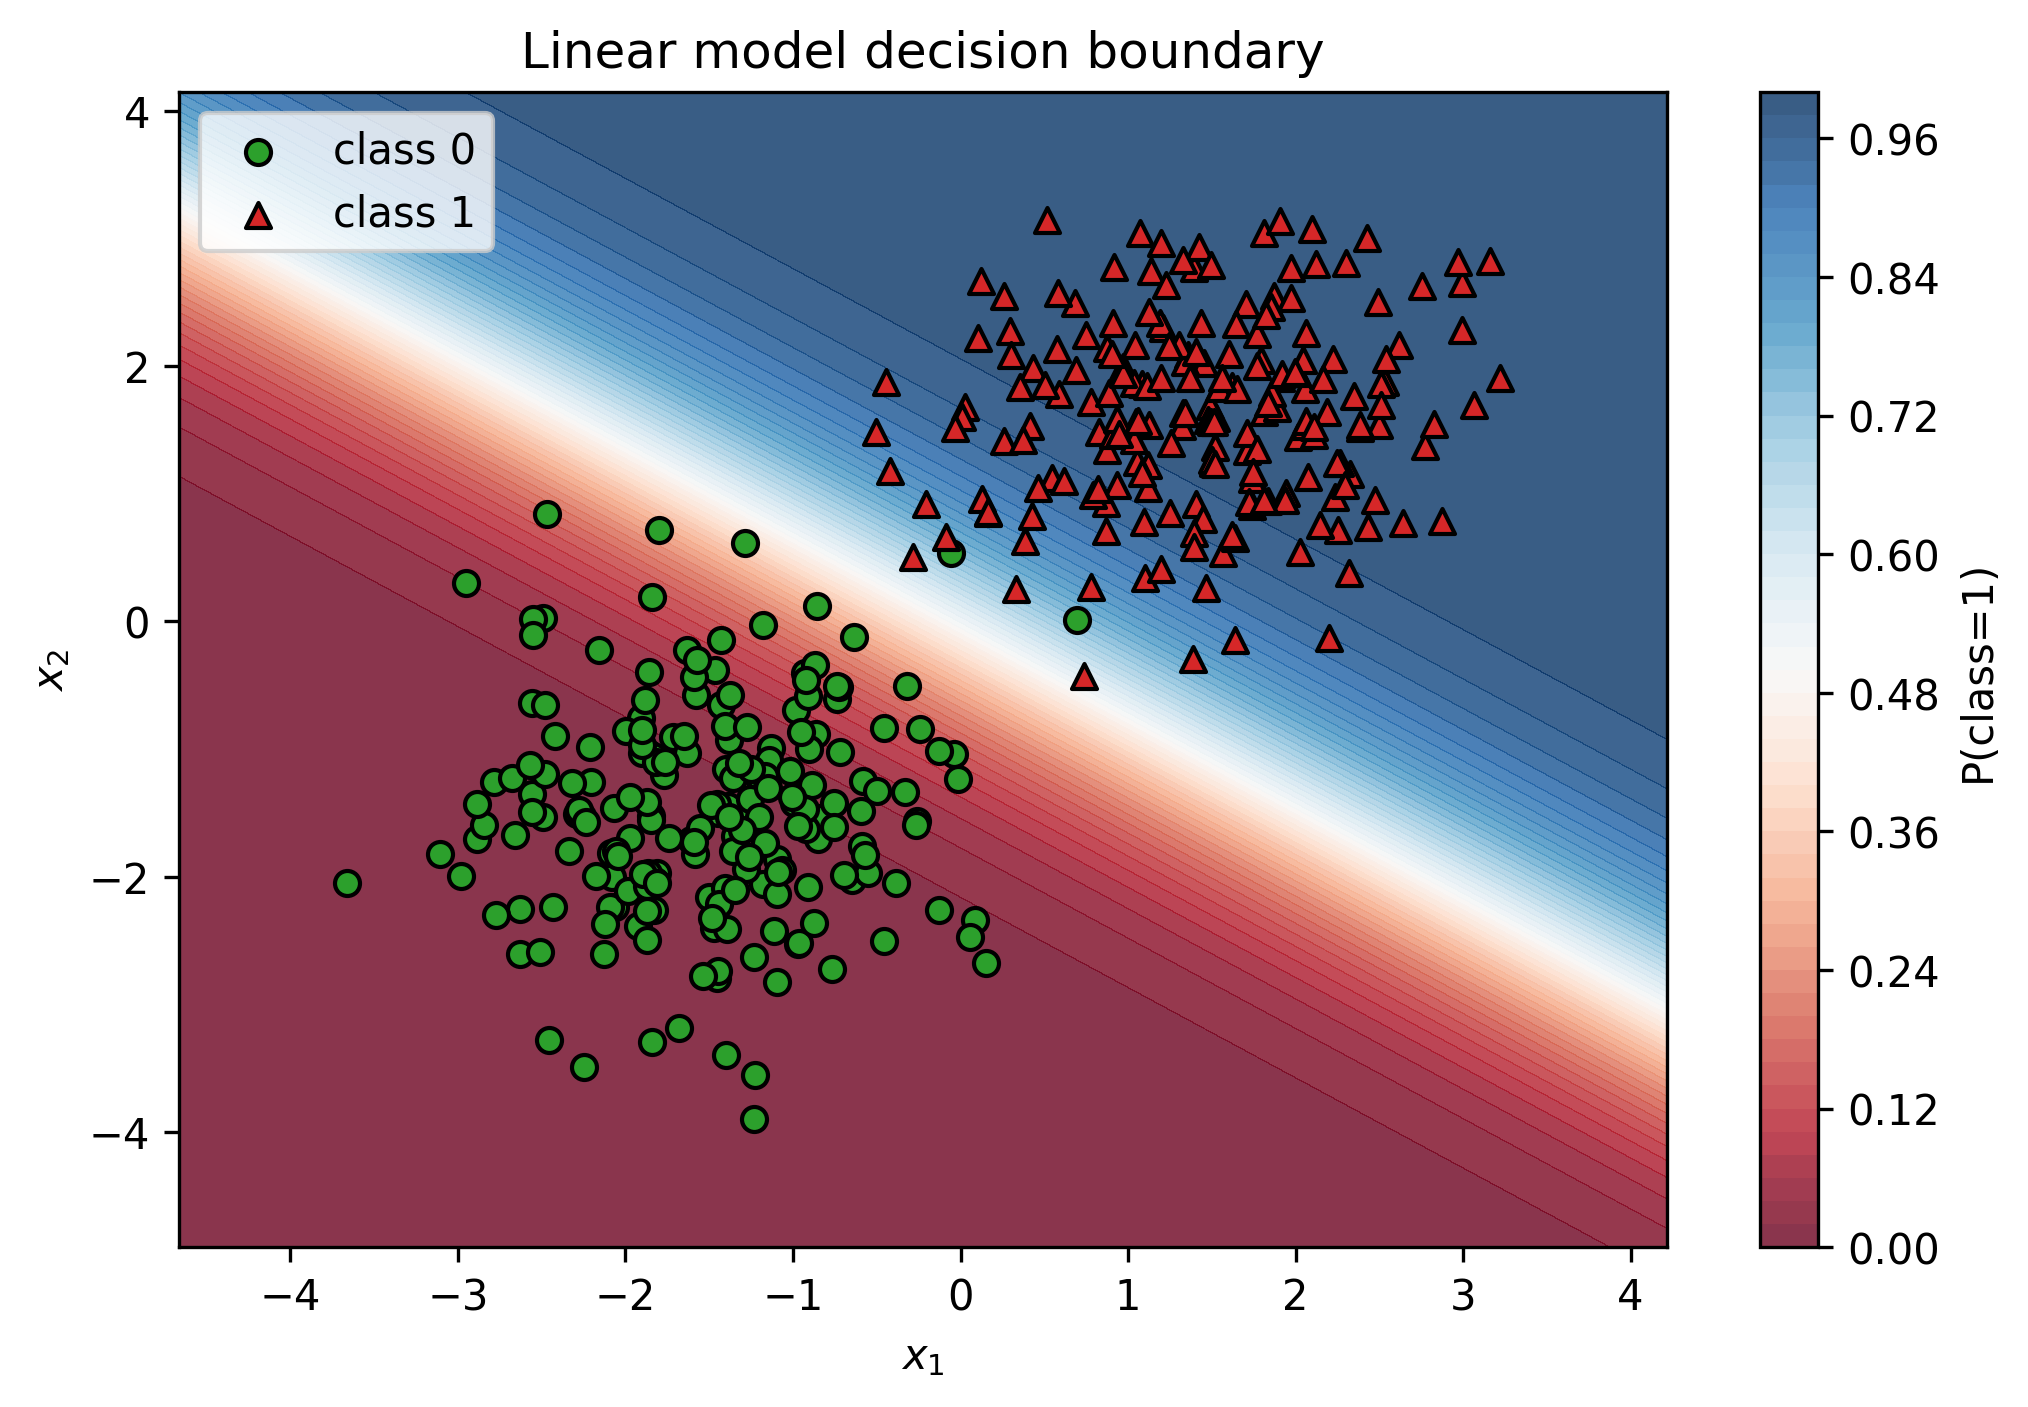

In [31]:
def plot_decision_boundary(model: nn.Module, X: torch.Tensor, y: torch.Tensor, title: str):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(x_min, x_max, 200),
        torch.linspace(y_min, y_max, 200),
        indexing='ij',
    )
    grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)
    with torch.no_grad():
        logits = model(grid)
        probs = logits.sigmoid().reshape(200, 200)
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    contour = ax.contourf(grid_x, grid_y, probs, levels=50, cmap='RdBu', alpha=0.8)
    fig.colorbar(contour, ax=ax, label='P(class=1)')
    for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
        mask = y == label
        ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, edgecolors='k', label=f'class {label}')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    plt.show()

plot_decision_boundary(model, X, y, 'Linear model decision boundary')

## 3. Magnitude Pruning

Magnitude pruning removes parameters with the smallest absolute values under the assumption that their contribution to the output is limited. For a weight matrix $\mathbf{W}$ we compute a mask $\mathbf{M}$ such that:

$$
M_{ij} = 
\begin{cases}
0 & 	\text{if } |W_{ij}| < 	au, \
1 & 	\text{otherwise}
\end{cases}
$$

where the threshold $	au$ is chosen so that a desired sparsity level is achieved. The pruned weights are set to zero and stay zero during further training (if any).

In [32]:
def magnitude_prune(model: nn.Module, amount: float = 0.5) -> Dict[str, torch.Tensor]:
    assert 0.0 <= amount < 1.0
    with torch.no_grad():
        weights = torch.cat([
            param.abs().flatten() for name, param in model.named_parameters() if 'weight' in name
        ])
        threshold = torch.quantile(weights, amount)
        masks = {}
        for name, param in model.named_parameters():
            if 'weight' in name:
                mask = (param.abs() >= threshold).float()
                param.mul_(mask)
                masks[name] = mask
        return masks

pruned_masks = magnitude_prune(model, amount=0.6)
print({name: mask.mean().item() for name, mask in pruned_masks.items()})

{'linear.weight': 0.5}


After pruning 60% of the weights we still achieve a nearly identical decision boundary because the dataset is linearly separable and the model is small. This demonstrates that significant sparsity can often be introduced without hurting accuracy.

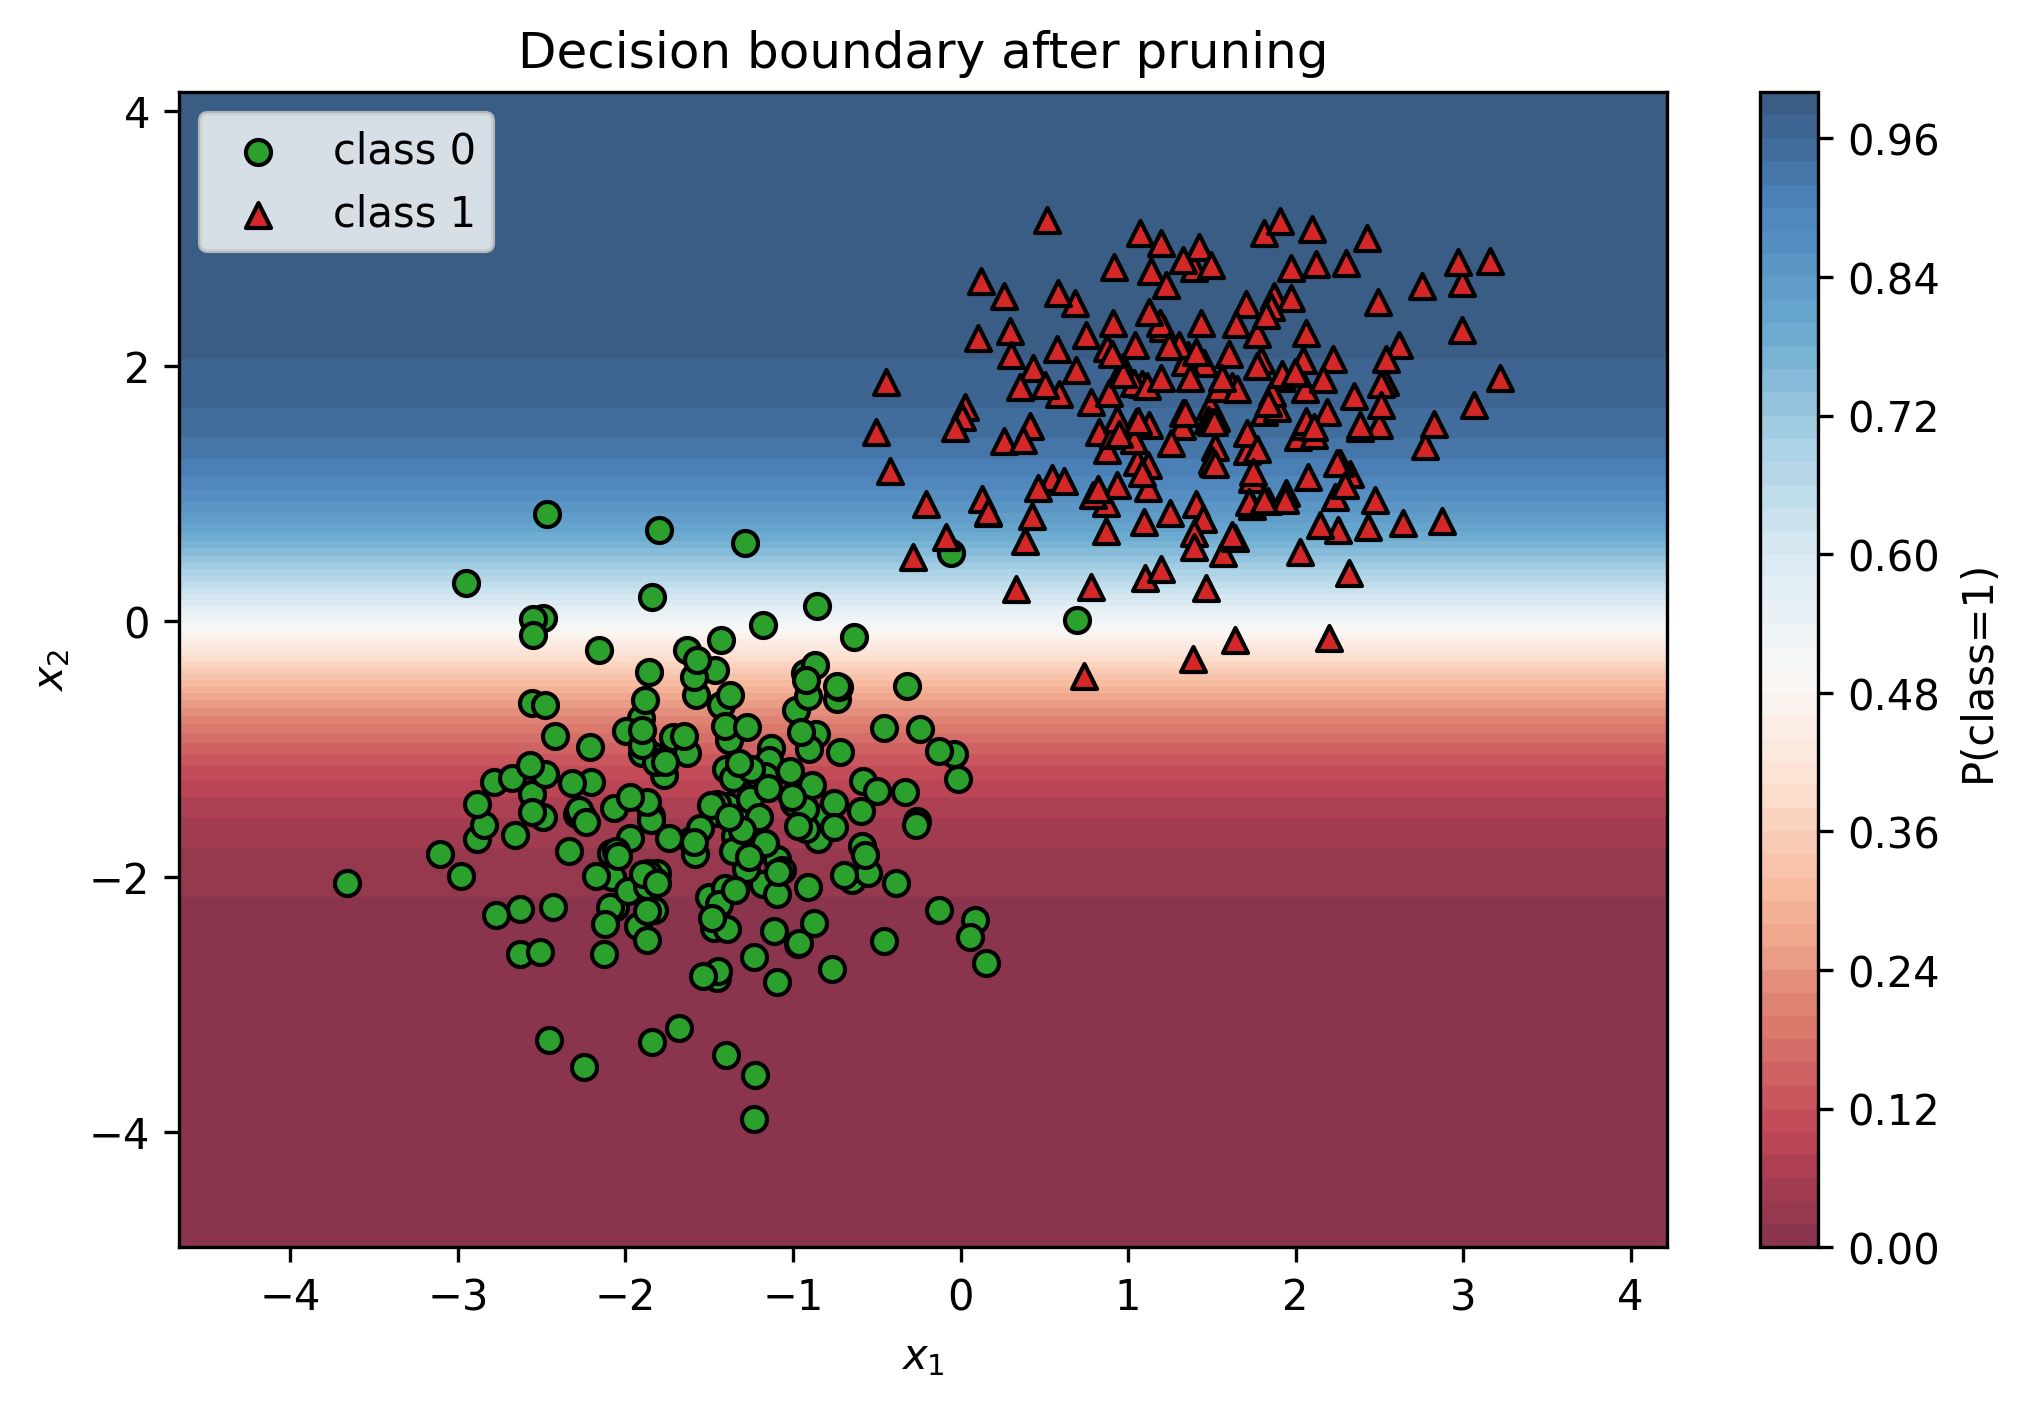

Accuracy after pruning: 0.962


In [33]:
plot_decision_boundary(model, X, y, 'Decision boundary after pruning')
with torch.no_grad():
    logits = model(X)
    preds = (logits.sigmoid() > 0.5).long()
    acc = (preds == y).float().mean().item()
print(f'Accuracy after pruning: {acc:.3f}')

## 4. Knowledge Distillation on the Classification Task

Knowledge distillation (KD) transfers information from a large teacher network to a smaller student. Let $z_t$ and $z_s$ denote the teacher and student logits respectively. KD minimizes a convex combination of the standard cross-entropy with the ground-truth labels and a temperature-scaled KL divergence between the teacher and student distributions:

$$
\mathcal{L}_{\text{KD}} = (1 - \alpha) \mathcal{L}_{	\text{CE}}(z_s, y) + \alpha T^2 \mathrm{KL}\big(\sigma(z_t / T) \| \sigma(z_s / T)\big).
$$

The temperature $T$ softens the probability distribution and $\alpha$ controls the trade-off between hard labels and soft targets. Compared to a typical training loss where we only have the cross-entropy term, the KL divergence with the teacher logit distribution provides a richer signals, also referred to as "dark knowledge" that the cross-entropy term doesn't. 

I suggest watching [Julia Turc's video on KD](https://www.youtube.com/watch?v=jrJKRYAdh7I) to learn more. 

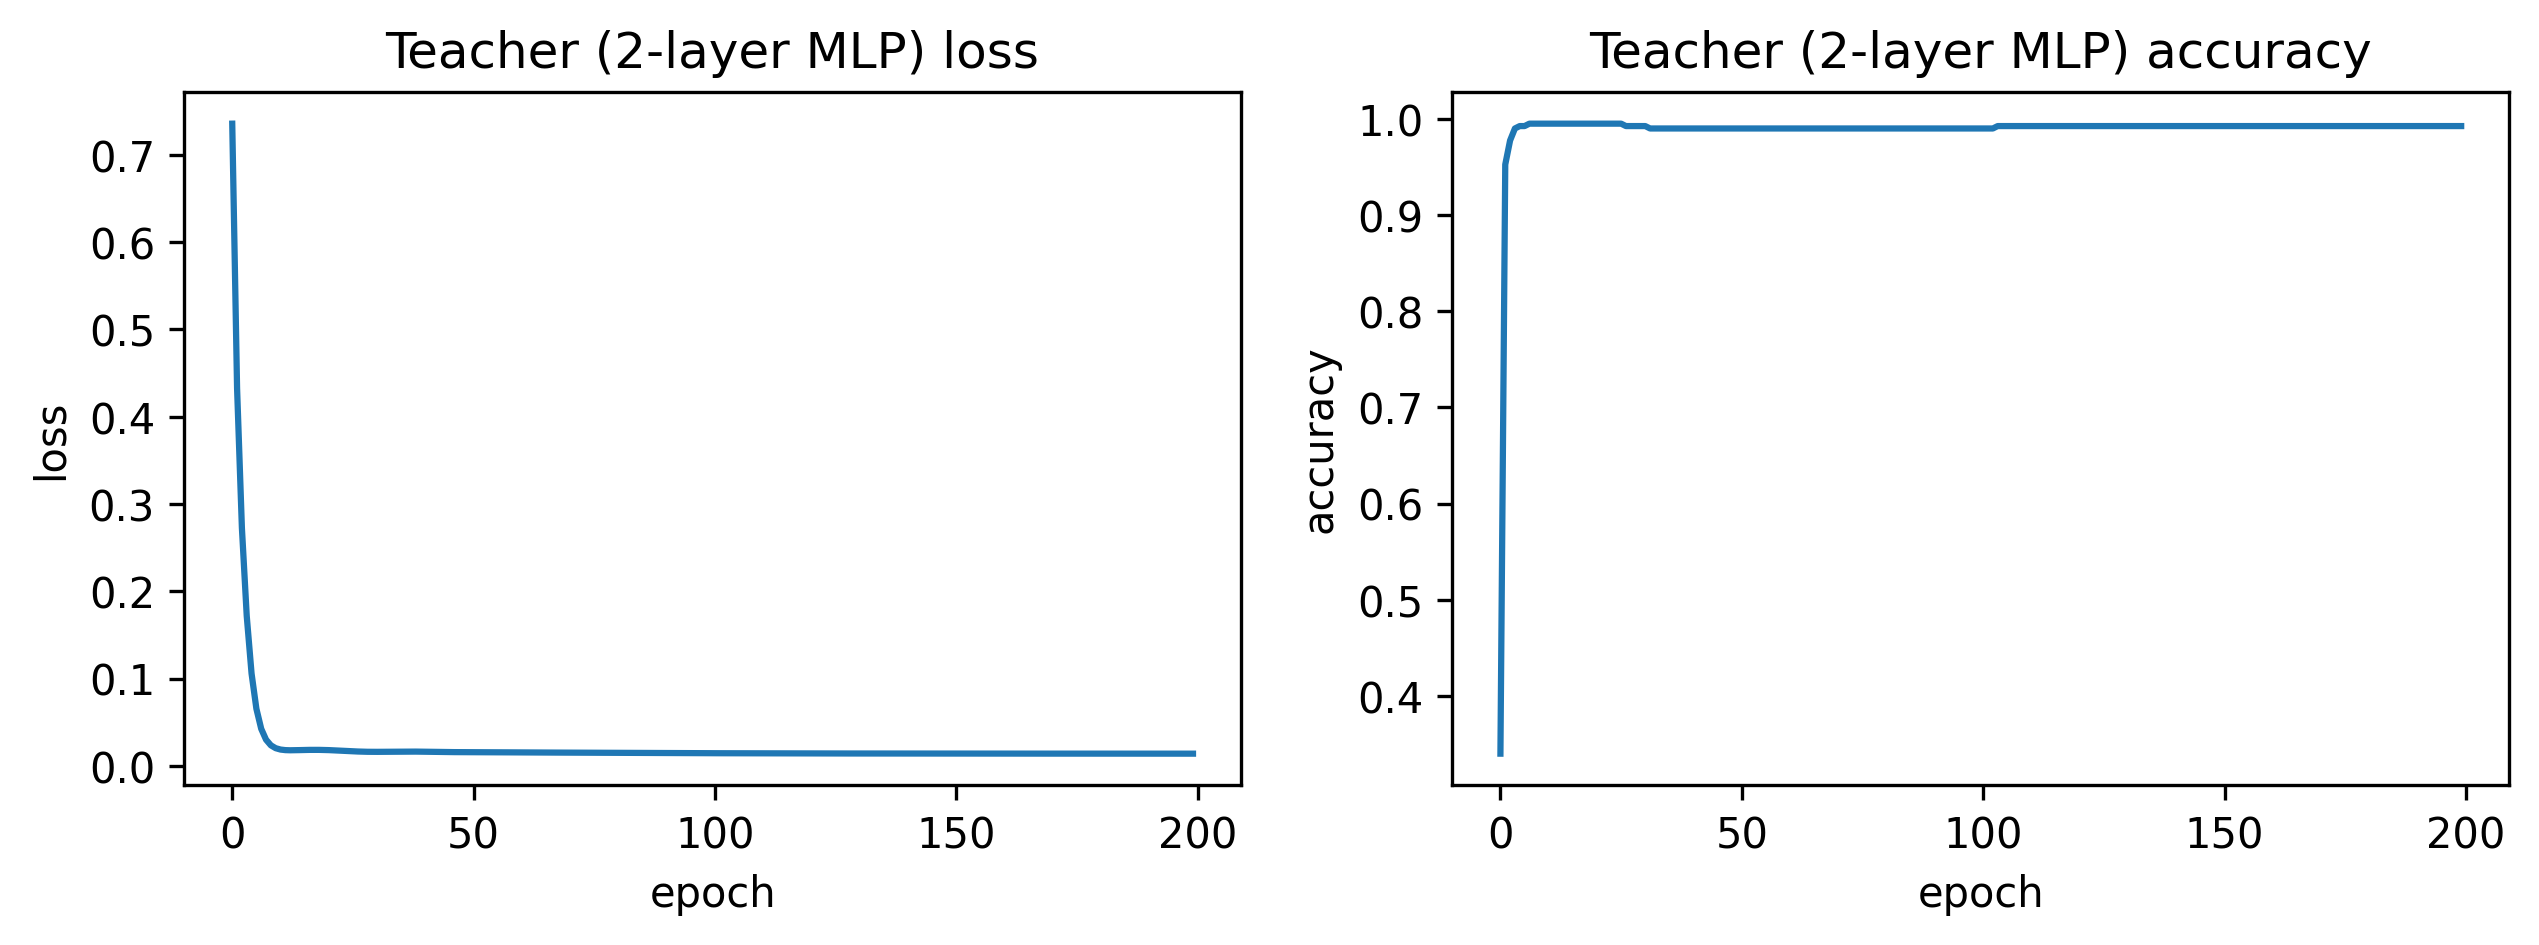

In [40]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


def train_teacher(model: nn.Module, data: Tuple[torch.Tensor, torch.Tensor], epochs: int = 200, lr: float = 0.05):
    X, y = data
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(epochs):
        model.train()
        logits = model(X)
        loss = F.cross_entropy(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            preds = logits.argmax(dim=-1)
            acc = (preds == y).float().mean().item()
        history.append((loss.item(), acc))
    return history


def distillation_step(student: nn.Module, teacher: nn.Module, inputs: torch.Tensor, targets: torch.Tensor,
                      optimizer: torch.optim.Optimizer, alpha: float = 0.7, temperature: float = 2.0):
    student.train()
    teacher.eval()
    student_logits = student(inputs)
    with torch.no_grad():
        teacher_logits = teacher(inputs)
    hard_loss = F.cross_entropy(student_logits, targets)
    soft_loss = F.kl_div(
        F.log_softmax(student_logits / temperature, dim=-1),
        F.softmax(teacher_logits / temperature, dim=-1),
        reduction='batchmean',
    ) * (temperature ** 2)
    loss = alpha * soft_loss + (1 - alpha) * hard_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        preds = student_logits.argmax(dim=-1)
        acc = (preds == targets).float().mean().item()
    return loss.item(), acc


teacher = MLPClassifier(in_dim=2, hidden_dim=16)
teacher_history = train_teacher(teacher, (X, y))
plot_history(teacher_history, 'Teacher (2-layer MLP)')

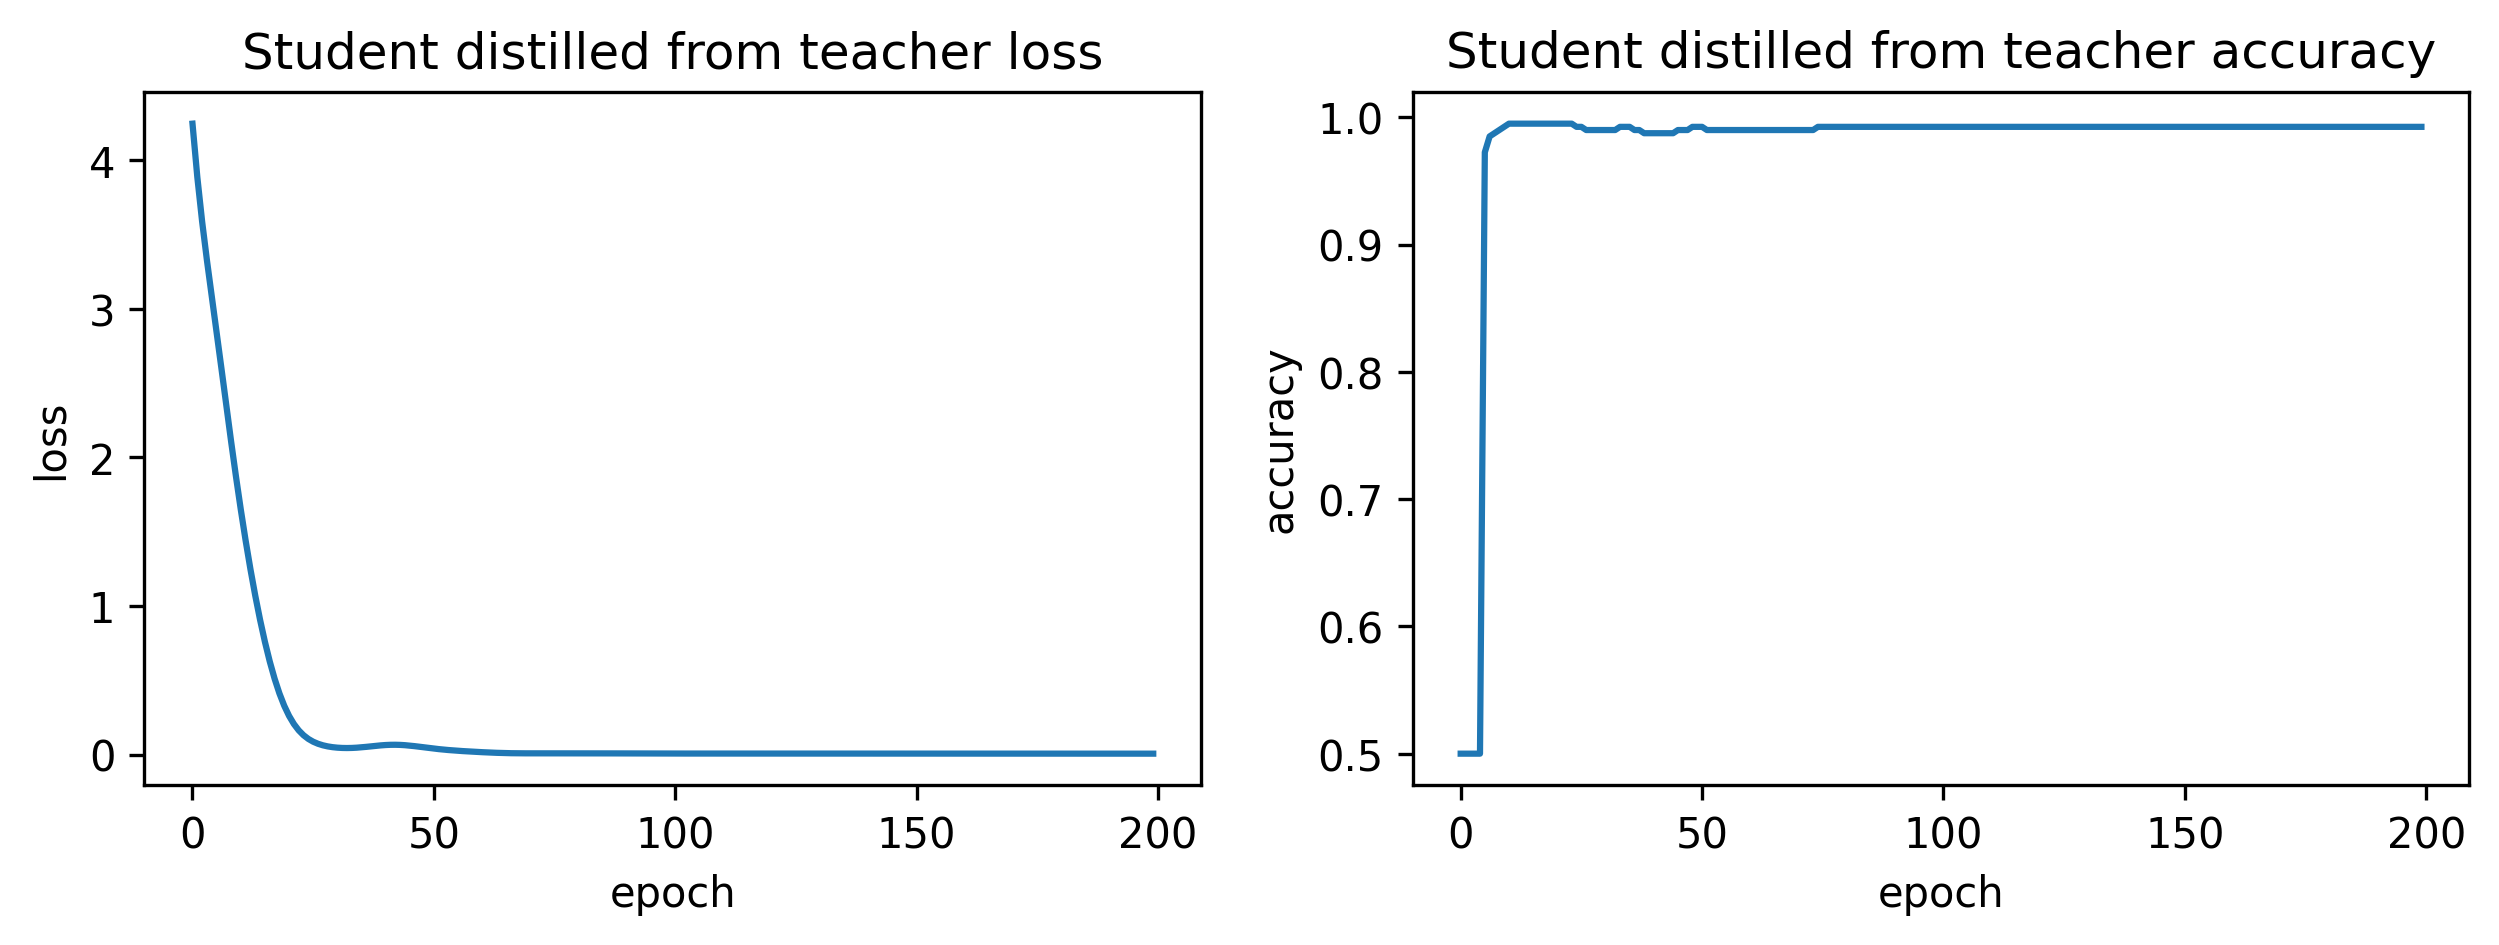

In [41]:
student = MLPClassifier(in_dim=2, hidden_dim=4)
optimizer = torch.optim.Adam(student.parameters(), lr=0.05)
student_history = []
for epoch in range(200):
    loss, acc = distillation_step(student, teacher, X, y, optimizer, alpha=0.8, temperature=3.0)
    student_history.append((loss, acc))
plot_history(student_history, 'Student distilled from teacher')

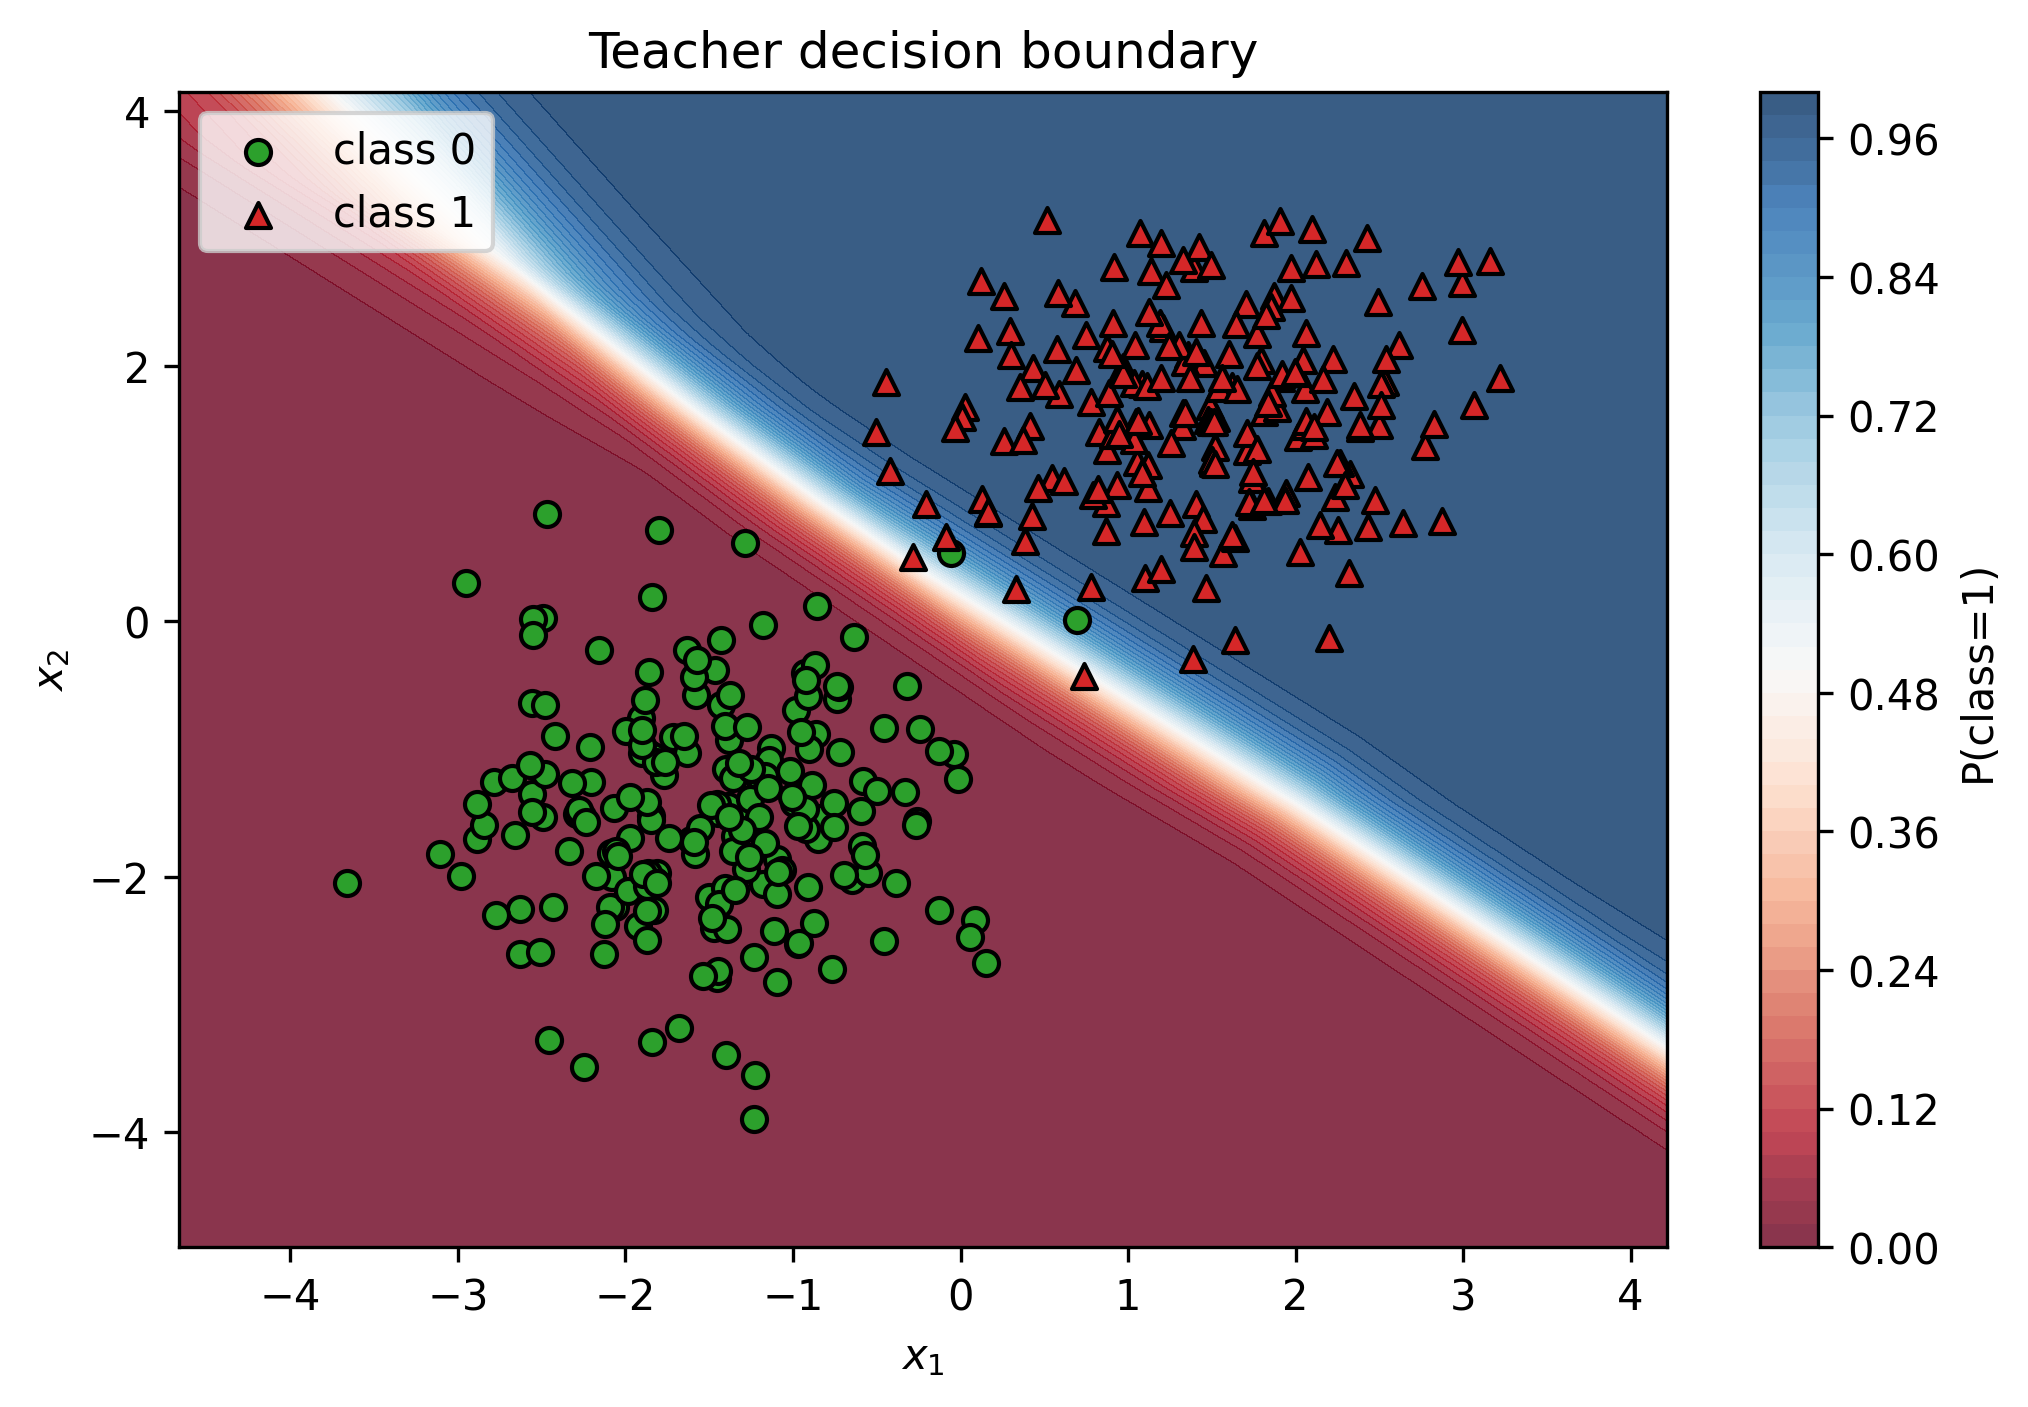

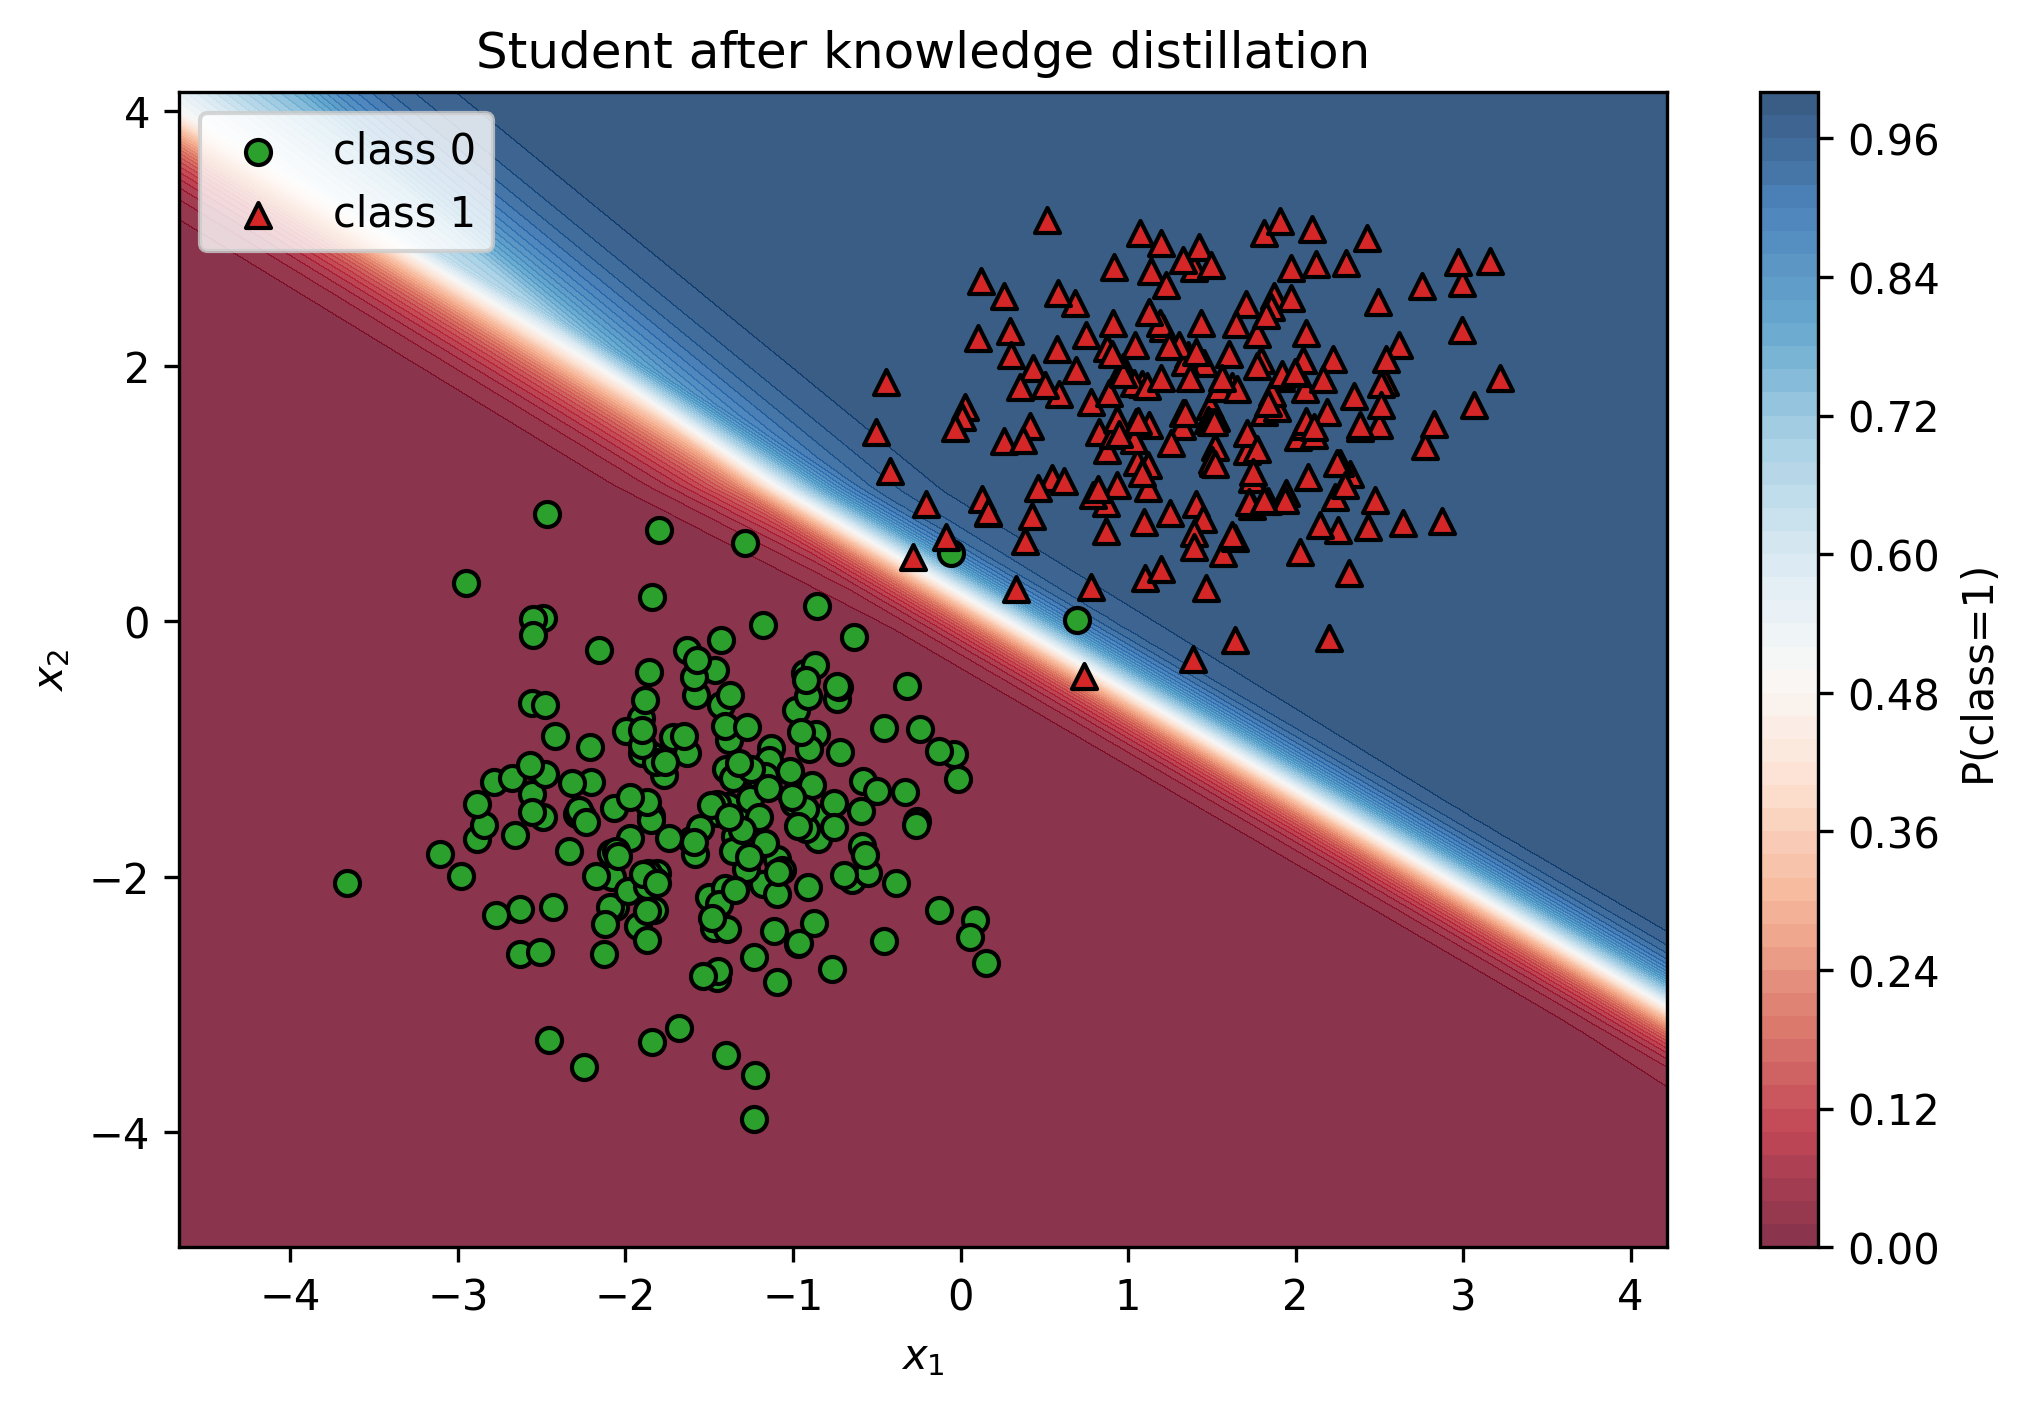

Teacher number of params: 82
Student number of params: 22


In [51]:
def plot_decision_boundary_logits(model: nn.Module, X: torch.Tensor, y: torch.Tensor, title: str):
    model.eval()
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    grid_x, grid_y = torch.meshgrid(
        torch.linspace(x_min, x_max, 200),
        torch.linspace(y_min, y_max, 200),
        indexing='ij',
    )
    grid = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=-1)
    with torch.no_grad():
        logits = model(grid)
        # apply softmax to get probabilities across classes, then take the prob for class 1
        probs_class_1 = F.softmax(logits, dim=-1)[:, 1].reshape(200, 200)
    fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
    contour = ax.contourf(grid_x, grid_y, probs_class_1, levels=50, cmap='RdBu', alpha=0.8)
    fig.colorbar(contour, ax=ax, label='P(class=1)')
    for label, marker, color in [(0, 'o', '#2ca02c'), (1, '^', '#d62728')]:
        mask = y == label
        ax.scatter(X[mask, 0], X[mask, 1], marker=marker, color=color, edgecolors='k', label=f'class {label}')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    plt.show()

plot_decision_boundary_logits(teacher, X, y, 'Teacher decision boundary')
plot_decision_boundary_logits(student, X, y, 'Student after knowledge distillation')
print("Teacher number of params:", sum(p.numel() for p in teacher.parameters()))
print("Student number of params:", sum(p.numel() for p in student.parameters()))


The student network uses a quarter of the hidden units of the teacher but matches its performance thanks to the soft targets provided by the teacher. This small-scale example mirrors real-world scenarios where KD enables substantial model compression.

## 5. Distilling a Toy `Qwen2.5`-Style Causal Language Model

We now turn to a sequence modeling task reminiscent of the Qwen family of large language models. The objective is to demonstrate how Hugging Face's trainer can be used to fine-tune a smaller student model from a larger teacher on a corpus of natural language. 

To keep the compute footprint small, we rely on a sliver of the FineWeb-Edu dataset while ensuring the workflow mirrors real-world knowledge distillation pipelines.


In [2]:
import torch
from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM,
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
)
from typing import Dict, List
from datasets import load_dataset, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

teacher_model_id = "Qwen/Qwen2.5-3B-Instruct"
student_model_id = "Qwen/Qwen2.5-0.5B-Instruct"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# KD hyperparams
ALPHA = 0.9       # weight on KL (teacher guidance)
TEMPERATURE = 2.0 # softening factor
MAX_LEN = 1024    # context length for training blocks
NUM_STREAM = 2000 # read only first 2k samples
SEED = 42

tokenizer = AutoTokenizer.from_pretrained(student_model_id, trust_remote_code=True)
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"


def _clean_text(text: str) -> str:
    return " ".join(text.strip().split())

# Stream and take first 2000 rows
streamed = load_dataset("HuggingFaceFW/fineweb-edu", "sample-10BT",
                        split="train", streaming=True)

rows: List[Dict] = []
for i, ex in enumerate(streamed):
    if "text" in ex and ex["text"]:
        rows.append({"text": _clean_text(ex["text"])})
    if len(rows) >= NUM_STREAM:
        break

raw_ds = Dataset.from_list(rows)

# Tokenize then pack into fixed-length blocks
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=False)

tokenized = raw_ds.map(tokenize_fn, batched=True, remove_columns=["text"])

# Concatenate then split into MAX_LEN blocks (GPT-style)
def group_texts(examples):
    # Concatenate
    concat_ids = []
    for ids in examples["input_ids"]:
        concat_ids.extend(ids + [tokenizer.eos_token_id])
    total_len = (len(concat_ids) // MAX_LEN) * MAX_LEN
    concat_ids = concat_ids[:total_len]
    # Make blocks
    input_ids = [concat_ids[i:i+MAX_LEN] for i in range(0, total_len, MAX_LEN)]
    attention_mask = [[1]*MAX_LEN for _ in input_ids]
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": input_ids.copy()}

lm_ds = tokenized.map(group_texts, batched=True, batch_size=1000)
lm_ds = lm_ds.shuffle(seed=SEED)
splits = lm_ds.train_test_split(test_size=0.1, seed=SEED)
train_ds, eval_ds = splits["train"], splits["test"]

Resolving data files:   0%|          | 0/2410 [00:00<?, ?it/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Again, we use the LoRA adapter to tune the student model in a parameter efficient manner. 

In [3]:
# Student (trainable)
student = AutoModelForCausalLM.from_pretrained(
    student_model_id,
    trust_remote_code=True,
    dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
)
student.to(DEVICE)

# LoRA for VRAM efficiency
from peft import LoraConfig, get_peft_model
lora = LoraConfig(r=32, lora_alpha=64, lora_dropout=0.05,
                  target_modules=["q_proj","k_proj","v_proj","o_proj","gate_proj","up_proj","down_proj","w1","w2"],
                  bias="none", task_type="CAUSAL_LM")
student = get_peft_model(student, lora)

# Teacher (frozen, eval)
teacher = AutoModelForCausalLM.from_pretrained(
    teacher_model_id,
    trust_remote_code=True,
    dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
)
teacher.to(DEVICE).eval()
for p in teacher.parameters():
    p.requires_grad = False

collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Let's now implement the KD Loss, as a convex combination of the cross-entropy and KL-divergence with temperature. 

In [4]:
import torch.nn.functional as F
from transformers.trainer import Trainer

class KDTrainer(Trainer):
    def __init__(self, teacher_model, temperature=2.0, alpha=0.9, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        self.temperature = temperature
        self.alpha = alpha

    # Accept extra kwargs for forward-compat (e.g., num_items_in_batch)
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        outputs = model(**inputs)
        s_logits = outputs.logits  # (B, T, V)

        with torch.no_grad():
            t_outputs = self.teacher(
                input_ids=inputs["input_ids"],
                attention_mask=inputs.get("attention_mask", None)
            )
            t_logits = t_outputs.logits

        # Shift for next-token prediction
        s_logits = s_logits[:, :-1, :].contiguous()
        t_logits = t_logits[:, :-1, :].contiguous()
        labels   = inputs["labels"][:, 1:].contiguous()

        # Hard-label CE (standard LM loss)
        ce_loss = F.cross_entropy(
            s_logits.view(-1, s_logits.size(-1)),
            labels.view(-1),
            ignore_index=-100
        )

        # Soft-label KL (distillation)
        tau = self.temperature
        s_log_probs = F.log_softmax(s_logits / tau, dim=-1)
        t_probs     = F.softmax(t_logits / tau, dim=-1)
        kl = F.kl_div(s_log_probs, t_probs, reduction="batchmean") * (tau * tau)

        loss = self.alpha * kl + (1.0 - self.alpha) * ce_loss
        return (loss, outputs) if return_outputs else loss

Let's now tune the model!

In [5]:
args = TrainingArguments(
    output_dir="logs/distill_qwen2_0p6_from_4b",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    bf16=(DEVICE=="cuda"),
    learning_rate=1e-4,
    weight_decay=0.0,
    warmup_ratio=0.03,
    num_train_epochs=1,
    logging_steps=20,
    eval_strategy="steps",
    eval_steps=20,
    save_steps=500,
    save_total_limit=2,
    report_to="none",
)

trainer = KDTrainer(
    model=student,
    teacher_model=teacher,
    temperature=TEMPERATURE,
    alpha=ALPHA,
    args=args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    data_collator=collator,
)

trainer.train()

/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: warning: librt.so.1, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/zeus/miniconda3/envs/cloudspace/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/h

TrainOutput(global_step=119, training_loss=25199.85425420168, metrics={'train_runtime': 372.5347, 'train_samples_per_second': 5.087, 'train_steps_per_second': 0.319, 'total_flos': 4371837730160640.0, 'train_loss': 25199.85425420168, 'epoch': 1.0})

Clearly, perplexity is improving using the knowledge distillation process.

## 6. Speculative Decoding

Speculative decoding accelerates auto-regressive generation by letting a fast draft model propose multiple tokens which are then verified (and possibly corrected) by the slower, high-quality target model. Suppose the draft proposes tokens $d_{1:k}$. The target evaluates the extended prefix once and either accepts or rejects each proposal sequentially. If the $j$-th token is rejected, the target produces its own token $t_j$ and the draft is restarted from the new prefix.

In expectation the number of target forward passes is reduced by approximately the proposal length, yielding significant speed-ups when the draft is reasonably accurate.

I suggest watching the [IBM video on Speculative Decoding](https://www.youtube.com/watch?v=VkWlLSTdHs8).

In [13]:
import time, math, torch
from typing import Tuple
from transformers import PreTrainedModel

# --- Greedy with KV cache --------------------------------------------------
@torch.inference_mode()
def generate_greedy(model: PreTrainedModel, input_ids: torch.Tensor, max_new_tokens: int):
    model.eval()
    if hasattr(model.config, "use_cache"):
        model.config.use_cache = True

    generated = input_ids.clone()
    past = None
    total_tokens_proc = 0

    # First pass: full prompt
    out = model(input_ids=generated, attention_mask=torch.ones_like(generated), use_cache=True)
    past = out.past_key_values
    total_tokens_proc += generated.size(1)

    for _ in range(max_new_tokens):
        out = model(input_ids=generated[:, -1:], use_cache=True, past_key_values=past)
        past = out.past_key_values
        next_tok = out.logits[:, -1, :].argmax(-1, keepdim=True)
        generated = torch.cat([generated, next_tok], dim=-1)
        total_tokens_proc += 1

    return generated, total_tokens_proc

@torch.inference_mode()
def speculative_decode(
    draft: PreTrainedModel,
    target: PreTrainedModel,
    input_ids: torch.Tensor,
    max_new_tokens: int,
    proposal_window: int = 4,
    # optional anti-repeat for DRAFT only (keeps target pristine/greedy)
) -> Tuple[torch.Tensor, int, int, int, int, float]:
    """
    Returns:
      generated_ids,
      target_calls,          # number of target forward passes
      draft_tokens_proc,     # tokens processed by the draft (compute proxy)
      target_tokens_proc,    # tokens processed by the target (compute proxy)
      emitted_tokens,        # how many tokens appended to output
      accept_ratio           # accepted_draft_tokens / proposed_draft_tokens
    """
    for m in (draft, target):
        m.eval()
        if hasattr(m.config, "use_cache"):
            m.config.use_cache = True

    generated = input_ids.clone()                    # (B, S)
    emitted = 0
    target_calls = 0
    draft_tokens_proc = 0
    target_tokens_proc = 0
    proposed_total = 0
    accepted_total = 0

    # warm caches
    d = draft(input_ids=generated, attention_mask=torch.ones_like(generated), use_cache=True)
    draft_cache = d.past_key_values
    draft_tokens_proc += generated.size(1)

    t = target(input_ids=generated, attention_mask=torch.ones_like(generated), use_cache=True)
    target_cache = t.past_key_values
    target_tokens_proc += generated.size(1)

    def _draft_step(last_token, cache):
        out = draft(input_ids=last_token, use_cache=True, past_key_values=cache)
        logits = out.logits[:, -1, :]                # (B, V)
        # keep penalties off for baseline; if we turn them on, mirror on teacher
        next_tok = logits.argmax(dim=-1, keepdim=False).unsqueeze(1)  # (B, 1)
        return out.past_key_values, next_tok

    while emitted < max_new_tokens:
        steps = min(proposal_window, max_new_tokens - emitted)

        # snapshot caches BEFORE proposing
        draft_cache_before = draft_cache
        target_cache_before = target_cache

        # 1) propose K tokens with the draft (advance draft_cache temporarily)
        prop_tokens = []
        for _ in range(steps):
            last = generated[:, -1:]
            draft_cache, d_tok = _draft_step(last, draft_cache)
            prop_tokens.append(d_tok)
            draft_tokens_proc += 1
        prop_seq = torch.cat(prop_tokens, dim=1)
        proposed_total += steps

        # 2) teacher verifies whole window from target_cache_before
        t_out = target(input_ids=prop_seq, use_cache=True, past_key_values=target_cache_before)
        target_calls += 1
        target_tokens_proc += prop_seq.size(1)
        t_argmax = t_out.logits.argmax(dim=-1)

        matches = (t_argmax == prop_seq)[0].to(torch.int32)
        prefix_len = int(torch.cumprod(matches, dim=0).sum().item())
        accepted_total += prefix_len

        if prefix_len == steps:
            # full accept
            generated = torch.cat([generated, prop_seq], dim=1)
            emitted += steps
            # advance target cache to t_out (already consumed K)
            target_cache = t_out.past_key_values
            # advance draft cache is already correct
        else:
            # accept prefix, then teacher token at first mismatch
            if prefix_len > 0:
                take = prop_seq[:, :prefix_len]
                generated = torch.cat([generated, take], dim=1)
                emitted += prefix_len

            teacher_tok = t_argmax[:, prefix_len:prefix_len+1]
            generated = torch.cat([generated, teacher_tok], dim=1)
            emitted += 1

            accepted_seq = torch.cat([prop_seq[:, :prefix_len], teacher_tok], dim=1)

            # realign *from snapshots* (before proposal):
            t_out2 = target(input_ids=accepted_seq, use_cache=True, past_key_values=target_cache_before)
            target_calls += 1
            target_tokens_proc += accepted_seq.size(1)
            target_cache = t_out2.past_key_values

            d_out2 = draft(input_ids=accepted_seq, use_cache=True, past_key_values=draft_cache_before)
            draft_tokens_proc += accepted_seq.size(1)
            draft_cache = d_out2.past_key_values

    accept_ratio = accepted_total / max(proposed_total, 1)
    return generated, target_calls, draft_tokens_proc, target_tokens_proc, emitted, accept_ratio


def benchmark(tokenizer, teacher, student, prompt_text: str, max_new_tokens=64, proposal_window=8, device="cuda"):
    messages = [{"role":"user","content": prompt_text}]
    prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt").to(device)

    def _sync():
        if torch.cuda.is_available(): torch.cuda.synchronize()

    # Teacher greedy
    _sync(); t0 = time.perf_counter()
    t_greedy_out, t_greedy_proc = generate_greedy(teacher, prompt, max_new_tokens)
    _sync(); t1 = time.perf_counter()
    t_greedy_time = t1 - t0
    t_greedy_tps = max_new_tokens / max(t_greedy_time, 1e-9)

    # Speculative
    _sync(); t2 = time.perf_counter()
    spec_out, tgt_calls, draft_tok, target_tok, emitted, accept_rate = speculative_decode(
        draft=student, target=teacher, input_ids=prompt,
        max_new_tokens=max_new_tokens, proposal_window=proposal_window
    )
    _sync(); t3 = time.perf_counter()
    spec_time = t3 - t2
    spec_tps = emitted / max(spec_time, 1e-9)

    print(f"\nPrompt: {prompt_text[:64]!r} | new_tokens={max_new_tokens} | window={proposal_window}")
    print(f"Teacher greedy : {t_greedy_time*1000:.1f} ms | {t_greedy_tps:.1f} tok/s | target_tokens={t_greedy_proc}")
    print(f"Speculative    : {spec_time*1000:.1f} ms | {spec_tps:.1f} tok/s "
          f"| target_calls={tgt_calls} | draft_tokens={draft_tok} | target_tokens={target_tok} | accept={accept_rate:.2f}")

    print("\nOutputs (truncated):")
    print("Teacher greedy:", tokenizer.decode(t_greedy_out[0], skip_special_tokens=True)[:260])
    print("Speculative   :", tokenizer.decode(t_greedy_out[0], skip_special_tokens=True)[:260])

# let's use the base model as the student for benchmarking (as it is already distilled)
student_base = AutoModelForCausalLM.from_pretrained(
    student_model_id,
    trust_remote_code=True,
    dtype=torch.float16 if DEVICE == "cuda" else torch.float32,
)
student_base.to(DEVICE).eval()
for p in student_base.parameters():
    p.requires_grad = False

benchmark(tokenizer, teacher, student_base, 
    "the story of humans starts as", max_new_tokens=2048, proposal_window=4, device=DEVICE)


Prompt: 'the story of humans starts as' | new_tokens=2048 | window=4
Teacher greedy : 35135.7 ms | 58.3 tok/s | target_tokens=2083
Speculative    : 34143.9 ms | 60.0 tok/s | target_calls=538 | draft_tokens=2151 | target_tokens=2151 | accept=0.98

Outputs (truncated):
Teacher greedy: system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
the story of humans starts as
assistant
The story of humans, as we understand it, begins with the emergence of Homo sapiens, which is believed to have occurred around 300,000 year
Speculative   : system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.
user
the story of humans starts as
assistant
The story of humans, as we understand it, begins with the emergence of Homo sapiens, which is believed to have occurred around 300,000 year


Even in this tiny example we reduce the number of expensive teacher forward passes by batching draft proposals, illustrating why speculative decoding yields meaningful inference speed-ups in practice.

### Key Takeaways

* **Pruning** removes redundant parameters and can maintain accuracy when applied judiciously.
* **Knowledge distillation** blends hard labels with soft teacher targets to train compact yet capable models.
* Hugging Face's **DistillationTrainer** streamlines KD workflows so that teacher-student training mirrors production pipelines.
* **Speculative decoding** turns an accurate yet slow model into an efficient inference pipeline by leveraging a fast draft model.